# Zindi Loan Default Prediction
## Objectives
To predict whether a loan is good or bad, based on the provided datasets.

# Data Exploration and Cleaning
### Things to consider
1. Missing values, outliers, imbalance of the data
2. Label encoding (for good_bad_flag column)
3. Merging the datasets

In [3]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import sklearn

In [349]:
# load the data
train_demograph = pd.read_csv('data/train/traindemographics.csv') # demographics of customers
train_prev_loans = pd.read_csv('data/train/trainprevloans.csv') # previous loans of customers
train_perf = pd.read_csv('data/train/trainperf.csv')

In [350]:
# preview the data
train_demograph.head()
# train_demograph.columns
# train_demograph.info

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [351]:
train_prev_loans.head() # notable features: loannumber, first due date vs first paid date, termdays vs (closed date - first due date)
# train_prev_loans.columns

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [352]:
train_perf.head()
# train.columns
# train.dtypes

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


Upon having a quick look at the datasets, we can see that there are a few columns that contain null values, and good_bad_flag column needs to be encoded according to the submission file. All datasets contain customer id, which can be used as a primary key to join the datasets.

In [353]:
# first payment deadline met or not -> 0 (no), 1 (yes)
train_prev_loans['firstduedate']
train_prev_loans['firstrepaiddate']
train_prev_loans['deadlinemet'] = np.where(train_prev_loans['firstduedate'] > train_prev_loans['firstrepaiddate'], 1, 0)
train_prev_loans.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate,deadlinemet
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000,1
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000,1
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000,0
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000,0
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000,0


In [354]:
# merge the datasets
# only merge deadlinemet column from previous loan dataset
data_temp = train_demograph.merge(train_prev_loans[['customerid', 'deadlinemet']], how='inner', on='customerid') # do we need previous loan data?
data = data_temp.merge(train_perf, how='inner', on='customerid') 
data.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,deadlinemet,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,1,301964962,2,2017-07-05 14:29:48.000000,2017-07-05 13:29:42.000000,10000.0,13000.0,30,8a858899538ddb8e0153a780c56e34bb,Good
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,0,301972172,2,2017-07-10 21:21:46.000000,2017-07-10 20:21:40.000000,10000.0,13000.0,30,NaN,Bad
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,0,301976271,4,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,10000.0,13000.0,30,NaN,Good
3,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,0,301976271,4,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,10000.0,13000.0,30,NaN,Good
4,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,1,301976271,4,2017-07-13 15:40:27.000000,2017-07-13 14:40:19.000000,10000.0,13000.0,30,NaN,Good


Looking at the merged dataset, we need to decide which features to preserve or drop, replace null values, etc. First, we'll fill in the missing values.

In [355]:
# explore the NaN values in the dataset
data.isnull().sum()

customerid                        0
birthdate                         0
bank_account_type                 0
longitude_gps                     0
latitude_gps                      0
bank_name_clients                 0
bank_branch_clients           13589
employment_status_clients      1363
level_of_education_clients    10229
deadlinemet                       0
systemloanid                      0
loannumber                        0
approveddate                      0
creationdate                      0
loanamount                        0
totaldue                          0
termdays                          0
referredby                    12891
good_bad_flag                     0
dtype: int64

In [356]:
# replace the nan values to "Unknown"
data['bank_branch_clients'] = data['bank_branch_clients'].fillna('Unknown')
data['employment_status_clients'] = data['employment_status_clients'].fillna('Unknown')
data['level_of_education_clients'] = data['level_of_education_clients'].fillna('Unknown')

# replace referredby column with 0 or 1, where 0 is no, 1 is yes
data['referredby'] = data['referredby'].notnull().astype('int')

In [357]:
# checking to see if we should combine any
data['employment_status_clients'].value_counts() #### visualize

Permanent        9138
Self-Employed    2319
Unknown          1363
Student           615
Unemployed        219
Retired            29
Contract           10
Name: employment_status_clients, dtype: int64

In [358]:
data['level_of_education_clients'].value_counts()

Unknown          10229
Graduate          2508
Secondary          485
Post-Graduate      435
Primary             36
Name: level_of_education_clients, dtype: int64

In [359]:
data['bank_account_type'].value_counts()

Savings    8311
Other      5228
Current     154
Name: bank_account_type, dtype: int64

We'll visualize the dataset to explore the characteristics of the merged dataset.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='good_bad_flag', ylabel='count'>

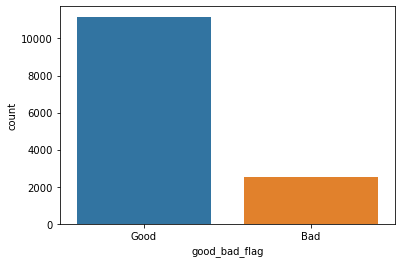

In [360]:
# visualization of train performance dataset
seaborn.countplot(data['good_bad_flag']) ##### comment: skewedness -> oversampling/k fold validation

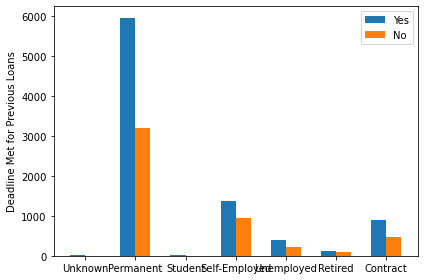

In [399]:
# does employment matter? (in regards to previous loan payment)
graph_data = pd.DataFrame({'employment_status': data['employment_status_clients'],'deadlinemet': data['deadlinemet']})

yes = graph_data[graph_data['deadlinemet'] == 1]
yes = yes.groupby('employment_status')['deadlinemet'].count()
no = graph_data[graph_data['deadlinemet'] == 0]
no = no.groupby('employment_status')['deadlinemet'].count()

labels = graph_data['employment_status'].unique()
x = np.arange(len(labels))

graph, ax = plt.subplots()
width = 0.3
ax.bar(x - width/2, yes, width, label='Yes')
ax.bar(x + width/2, no, width, label='No')

ax.set_ylabel('Deadline Met for Previous Loans')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

graph.tight_layout()
plt.show()

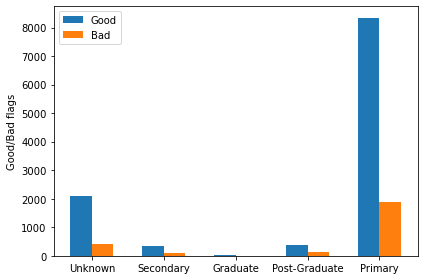

In [401]:
#### log visualization - when there is high variation
# does education matter?
graph_data = pd.DataFrame({'level_of_education': data['level_of_education_clients'],'good_bad_flag': data['good_bad_flag']})

good = graph_data[graph_data['good_bad_flag'] == 'Good']
good = good.groupby('level_of_education')['good_bad_flag'].count()
bad = graph_data[graph_data['good_bad_flag'] == 'Bad']
bad = bad.groupby('level_of_education')['good_bad_flag'].count()

labels = graph_data['level_of_education'].unique()
x = np.arange(len(labels))

graph, ax = plt.subplots()
width = 0.3
ax.bar(x - width/2, good, width, label='Good')
ax.bar(x + width/2, bad, width, label='Bad')

ax.set_ylabel('Good/Bad flags')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

graph.tight_layout()
plt.show()

We'll then encode the non-numerical columns in the dataset. For good_bad_flag, 1 indicates "Good" while 0 indicates "Bad". We will use scikit-learn's built in labeling encoder to achieve this.

In [246]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()

# convert non numerical values 
for name in data.columns:
    if data[name].dtype == object:
        data[name] = encoder.fit_transform(data[name])

In [247]:
data.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,deadlinemet,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,413,169,2,3.319219,6.528604,6,28,6,4,1,301964962,2,486,487,10000.0,13000.0,30,1,1
1,538,1465,2,3.325598,7.119403,12,28,1,4,0,301972172,2,1073,1073,10000.0,13000.0,30,0,0
2,759,1668,2,5.746100,5.563174,4,28,6,4,0,301976271,4,1405,1405,10000.0,13000.0,30,0,1
3,759,1668,2,5.746100,5.563174,4,28,6,4,0,301976271,4,1405,1405,10000.0,13000.0,30,0,1
4,759,1668,2,5.746100,5.563174,4,28,6,4,1,301976271,4,1405,1405,10000.0,13000.0,30,0,1


# Modeling and Evaluation
We'll split the dataset into train and test datasets, then try out different algorithms for the prediction model. Since the initla dataset contains a target label column, we'll use supervised learning methods.

In [249]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['good_bad_flag']) # drop the target column
y = data.iloc[:, -1] # only get the target column
# split the dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=103)

In [250]:
# import model from sklearn 
# support vector machine #### why? strength vs weakness? accuracy, speed, etc. why for this use case?
from sklearn import svm
classification_model_svm = svm.SVC(kernel='linear')
classification_model_svm.fit(x_train, y_train)

SVC(kernel='linear')

In [300]:
y_pred = classification_model_svm.predict(x_test)

# evaluate
#### confusion matrix
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.8147517039922103


### Preparing the test file

In [4]:
# test files 
test_demograph = pd.read_csv('data/test/testdemographics.csv') # demographics of customers
test_prev_loans = pd.read_csv('data/test/testprevloans.csv') # previous loans of customers
test_perf = pd.read_csv('data/test/testperf.csv')

# create a col in previous loans
test_prev_loans['firstduedate']
test_prev_loans['firstrepaiddate']
test_prev_loans['deadlinemet'] = np.where(test_prev_loans['firstduedate'] > test_prev_loans['firstrepaiddate'], 1, 0)

# merge the datasets
data_temp = test_demograph.merge(test_prev_loans[['customerid', 'deadlinemet']], how='inner', on='customerid')
test_data = data_temp.merge(test_perf, how='inner', on='customerid')

# replace nan values
test_data['bank_branch_clients'] = test_data['bank_branch_clients'].fillna('Unknown')
test_data['employment_status_clients'] = test_data['employment_status_clients'].fillna('Unknown')
test_data['level_of_education_clients'] = test_data['level_of_education_clients'].fillna('Unknown')
test_data['referredby'] = test_data['referredby'].notnull().astype('int')

### Get prediction and save as CSV file
With the preprocessed test file, we can get prediction result and export it as csv file.

In [344]:
customerid = test_data['customerid']

# convert non numerical values 
#### should've make a note of the inverse_transform error
for name in test_data.columns:
    if test_data[name].dtype == object:
        test_data[name] = encoder.fit_transform(test_data[name])

test_data.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,deadlinemet,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,237,41,2,5.296628,7.593965,7,3,0,4,1,301992953,2,217,211,10000,11500.0,15,0
1,357,116,2,6.354624,4.949031,5,3,2,4,0,301997095,14,186,179,40000,44000.0,30,0
2,357,116,2,6.354624,4.949031,5,3,2,4,0,301997095,14,186,179,40000,44000.0,30,0
3,357,116,2,6.354624,4.949031,5,3,2,4,0,301997095,14,186,179,40000,44000.0,30,0
4,357,116,2,6.354624,4.949031,5,3,2,4,1,301997095,14,186,179,40000,44000.0,30,0


In [345]:
y_test_pred = classification_model_svm.predict(test_data)

In [346]:
result = pd.DataFrame({'customerid': customerid, 'Good_Bad_Flag': y_test_pred})
result

,customerid,Good_Bad_Flag
0,8a858f305c8dd672015c93b1db645db4,1
1,8a858fde56eb02280156eb6dafc128ac,1
2,8a858fde56eb02280156eb6dafc128ac,1
3,8a858fde56eb02280156eb6dafc128ac,1
4,8a858fde56eb02280156eb6dafc128ac,1
...,...,...
1600,8a858e675b00c831015b06776ce75e69,1
1601,8a858e675b00c831015b06776ce75e69,1
1602,8a858e675b00c831015b06776ce75e69,1
1603,8a858e675b00c831015b06776ce75e69,1


In [347]:
result.to_csv('submission.csv')

In [6]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

test_data['customerid'] = le.fit_transform(test_data['customerid'])
test_data.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,deadlinemet,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,237,1976-08-28 00:00:00.000000,Savings,5.296628,7.593965,Heritage Bank,Unknown,Permanent,Unknown,1,301992953,2,36:45.0,36:38.0,10000,11500.0,15,0
1,357,1982-03-29 00:00:00.000000,Savings,6.354624,4.949031,First Bank,Unknown,Self-Employed,Unknown,0,301997095,14,31:11.0,30:01.0,40000,44000.0,30,0
2,357,1982-03-29 00:00:00.000000,Savings,6.354624,4.949031,First Bank,Unknown,Self-Employed,Unknown,0,301997095,14,31:11.0,30:01.0,40000,44000.0,30,0
3,357,1982-03-29 00:00:00.000000,Savings,6.354624,4.949031,First Bank,Unknown,Self-Employed,Unknown,0,301997095,14,31:11.0,30:01.0,40000,44000.0,30,0
4,357,1982-03-29 00:00:00.000000,Savings,6.354624,4.949031,First Bank,Unknown,Self-Employed,Unknown,1,301997095,14,31:11.0,30:01.0,40000,44000.0,30,0


In [7]:
test_data['customerid'] = le.inverse_transform(test_data['customerid'])

In [8]:
test_data['customerid']

0       8a858f305c8dd672015c93b1db645db4
1       8a858fde56eb02280156eb6dafc128ac
2       8a858fde56eb02280156eb6dafc128ac
3       8a858fde56eb02280156eb6dafc128ac
4       8a858fde56eb02280156eb6dafc128ac
                      ...               
1600    8a858e675b00c831015b06776ce75e69
1601    8a858e675b00c831015b06776ce75e69
1602    8a858e675b00c831015b06776ce75e69
1603    8a858e675b00c831015b06776ce75e69
1604    8a85881053bc33670153c79e8e84571a
Name: customerid, Length: 1605, dtype: object

In [10]:
for name in test_data.columns:
    if test_data[name].dtype == object:
        test_data[name] = le.fit_transform(test_data[name])

In [11]:
test_data['customerid'] = le.inverse_transform(test_data['customerid'])

ValueError: y contains previously unseen labels: [365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382
 383]

<AxesSubplot:>

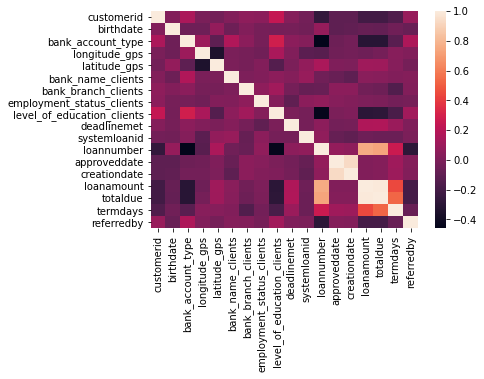

In [14]:
seaborn.heatmap(test_data.corr())

In [15]:
test_data.corr() #### feature engineering - causation (one is cause of another) and correlation

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,deadlinemet,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
customerid,1.000000,0.023765,0.160100,-0.008791,-0.029774,0.019403,0.058642,0.047108,0.241641,0.025647,-0.030693,-0.263797,-0.103047,-0.106771,-0.206779,-0.206208,-0.157183,0.091208
birthdate,0.023765,1.000000,-0.049416,-0.044383,0.077519,-0.050474,0.023677,-0.020262,-0.024317,-0.017536,-0.035770,0.083716,-0.103431,-0.091714,-0.077867,-0.083263,-0.043312,-0.068710
bank_account_type,0.160100,-0.049416,1.000000,0.104435,-0.105724,0.173932,0.051150,-0.017146,0.288086,0.051949,0.026328,-0.460802,-0.050272,-0.029310,-0.304390,-0.302748,-0.120466,0.165485
longitude_gps,-0.008791,-0.044383,0.104435,1.000000,-0.345387,-0.008738,-0.017085,-0.039311,0.152489,0.018466,-0.116921,-0.126802,-0.042287,-0.030472,-0.049489,-0.026307,0.038268,0.018516
latitude_gps,-0.029774,0.077519,-0.105724,-0.345387,1.000000,-0.001232,-0.019603,0.021769,-0.138760,0.000491,0.073357,0.160979,0.009513,0.005851,0.121212,0.110992,0.031359,-0.023178
bank_name_clients,0.019403,-0.050474,0.173932,-0.008738,-0.001232,1.000000,0.001830,0.015344,0.056636,0.026663,0.092631,-0.041097,-0.068021,-0.101351,0.045703,0.037971,0.017767,0.029742
bank_branch_clients,0.058642,0.023677,0.051150,-0.017085,-0.019603,0.001830,1.000000,0.061548,0.126134,-0.024877,-0.077644,-0.069098,0.049772,0.052169,-0.038394,-0.052253,-0.148027,0.022139
employment_status_clients,0.047108,-0.020262,-0.017146,-0.039311,0.021769,0.015344,0.061548,1.000000,0.028058,-0.097375,0.048387,0.069484,0.032376,0.023557,0.005342,-0.000867,-0.027347,-0.016538
level_of_education_clients,0.241641,-0.024317,0.288086,0.152489,-0.138760,0.056636,0.126134,0.028058,1.000000,-0.000977,-0.026072,-0.446733,-0.004252,0.009586,-0.291614,-0.287801,-0.176008,0.124559
deadlinemet,0.025647,-0.017536,0.051949,0.018466,0.000491,0.026663,-0.024877,-0.097375,-0.000977,1.000000,-0.023916,0.055600,-0.030365,-0.025195,0.171907,0.174055,0.103486,0.007325
